# 4. No pretrained model

Our last attempt will be to create a custom model without using a pretrained model. We will use our knowledge from tutorials. 

In [1]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

In [2]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda vesion:', cuda_version)
cudnn_version = sys_details["cudnn_version"]  
print('Cudnn vesion:', cudnn_version)

Cuda vesion: 11.2
Cudnn vesion: 8


## Preparation and model creation
For this model, we are only using downsampled images to 128x128 as the difference between 224x224 and 128x128 downscales was not big and as our model is not as optimized as MobileNetV2 or Xception, we were getting OOM messages at 224x224 downscaled images.

In [3]:
_train_dir = 'resized128/train'
_test_dir = 'resized128/test'
_img_width, _img_height = 128,128 
_batch_size = 32
_weights_name = 'maskedfaces128_no_pretrained.h5'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    _train_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    _train_dir, # same directory as training data
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 96658 images belonging to 2 classes.
Found 17057 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) 

test_generator = train_datagen.flow_from_directory(
    _test_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary')

Found 20067 images belonging to 2 classes.


In [6]:
model = Sequential()
model.add(Conv2D(_img_width/2, (3, 3), padding='same', activation='relu', input_shape=(_img_width, _img_height, 3)))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(_img_width/2, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.20))

model.add(Conv2D(_img_width, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(_img_width, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.20))

model.add(Conv2D(_img_width*2, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(_img_width*2, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.20))

model.add(Conv2D(_img_width*4, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(_img_width*4, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(_img_width*8, activation='relu'))
model.add(Dense(_img_width*4, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),  metrics=['accuracy'])
model.summary()

2021-12-28 23:05:54.614645: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-28 23:05:55.097474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9569 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                        

## Training the model
We have also added a checkpoint save weights with the best validation loss. You can also [skip](#skip) the training.

In [7]:
checkpointer = ModelCheckpoint(filepath=_weights_name, verbose=1, save_best_only=True)

We will train the model for 15 epochs.

In [8]:
hist = model.fit(train_generator, validation_data = valid_generator, epochs=15, callbacks=[checkpointer], verbose=True)

Epoch 1/15


2021-12-28 23:06:03.976744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


3021/3021 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9868
Epoch 00001: val_loss improved from inf to 0.74247, saving model to maskedfaces_no_pretrained.h5
3021/3021 [==============================] - 455s 149ms/step - loss: 0.0396 - accuracy: 0.9868 - val_loss: 0.7425 - val_accuracy: 0.6575
Epoch 2/15
3021/3021 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9962
Epoch 00002: val_loss improved from 0.74247 to 0.00864, saving model to maskedfaces_no_pretrained.h5
3021/3021 [==============================] - 431s 143ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 0.0086 - val_accuracy: 0.9975
Epoch 3/15
3021/3021 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9972
Epoch 00003: val_loss improved from 0.00864 to 0.00547, saving model to maskedfaces_no_pretrained.h5
3021/3021 [==============================] - 431s 143ms/step - loss: 0.0109 - accuracy: 0.9972 - val_loss: 0.0055 - val_accuracy: 0.9984
Epoch 4

Now we will plot the training history and evaluate our model on test data.

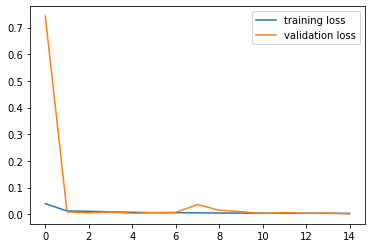

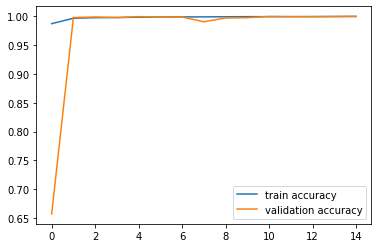

In [9]:
plt.figure()
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

<a id='skip'></a> If you want to skip the training, just uncomment the first or the second cell under this text.

In [ ]:
# wget
# _weights_name = 'maskedfaces128_no_pretrained.h5'

In [10]:
model.load_weights(_weights_name)

In [ ]:
train_score = model.evaluate(train_generator)
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(test_generator)
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

3021/3021 [==============================] - 364s 120ms/step - loss: 0.0015 - accuracy: 0.9996


train loss: 0.0014968521427363157 | train acc: 0.9996172189712524

606/628 [===========================>..] - ETA: 2s - loss: 0.0028 - accuracy: 0.9992

In [ ]:
model_predictions = model.predict(test_generator)

In [ ]:
preds = np.array(model_predictions > 0.5).astype(int).T[0]
labels = np.array(test_generator.classes)

f1 = f1_score(labels, preds)
print('F1 score: ', f1)

## Conclusion

Our model with pretrained Xception model with disabled learning ended up with much better accuracy. The F1 score is still poor. We will continue in next notebook (TODO link), with our final custom network. The training of this model was around 6 minutes per epoch on 128x128 images.

### 128x128 images
Our custom model with 128x128 images ended up with results:
- train loss: 
- train accuracy: 
- test loss: 
- test accuracy: 
- F1 score: 